In [109]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Normalizing Flow

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
import torch.optim as optim
import torch.utils.data 

# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
import math

from tqdm.auto import tqdm

class Flow(nn.Module):

    def invert(self, y):
        raise NotImplementedError()

    # def log_abs_det_jacobian(self, x, y):
    #     raise NotImplementedError()

    def forward(self, x, log_det_jacob):
        raise NotImplementedError()

    def __init__(self, event_dim = 1):
        # transform.Transform.__init__(self)
        nn.Module.__init__(self)
        self._event_dim = event_dim

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

    @property
    def event_dim(self):
        return self._event_dim

    @constraints.dependent_property(is_discrete=False)
    def domain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)

    @constraints.dependent_property(is_discrete=False)
    def codomain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)

class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, base_distrib, device):
        super().__init__()
        self.device = device
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim, self.device))
        # self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_distrib = base_distrib
        # self.final_density = distrib.TransformedDistribution(density, self.transforms)
        # self.log_det = []

    def forward(self, x):
        # Applies series of flows
        log_det_jacob = torch.zeros((x.shape[0]), device = self.device, dtype = torch.float32)
        for b in range(len(self.bijectors)):
            x, log_det_jacob = self.bijectors[b](x, log_det_jacob)
        return x, log_det_jacob

    def invert(self, z):
        for layer in reversed(self.bijectors):
            z = layer.invert(z)
        return z
    
    def log_prob(self, x):
        y, log_det_jacob = self(x)
        return self.base_distrib.log_prob(y) + log_det_jacob

    # def sample(self):
    #     # dodać cude
    #     with torch.no_grad():
    #         base_dens_samples = self.base_density.sample()
    #         out_samples, _ = self.forward(base_dens_samples)
    #     return out_samples

    # def log_prob(self, y):
    #     #dodać cude
    #     log_det_reversed_order = []
    #     for b in reversed(range(len(self.bijectors))):
    #         log_det_reversed_order.append(self.bijectors[b].log_abs_det_jacobian(y))
    #         y = self.bijectors[b]._inverse(y)
    #         print(y)
    #     log_prob_base = self.base_density.log_prob(y)
    #     jacobian_part = torch.sum(torch.stack(log_det_reversed_order))
    #     return log_prob_base - jacobian_part

class CouplingFlow(Flow):
    def __init__(self, dim, device, n_hidden=128, n_layers=3, activation=nn.ReLU, last_s_activation = nn.Tanh):
        super(CouplingFlow, self).__init__()
        self.k = dim // 2
        self.t = self.t_transform_net(self.k, self.k, n_hidden, n_layers, activation)
        self.s = self.s_transform_net(self.k, self.k, n_hidden, n_layers, activation, last_s_activation)
        self.device = device
        self.dim = dim
        # self.register_buffer("mask",torch.cat((torch.ones(self.k), torch.zeros(self.dim - self.k))).detach())
        self.init_parameters()
        # self.bijective = True


    def t_transform_net(self, n_in, n_out, n_hidden, n_layer, activation):
        net = nn.ModuleList()
        for l in range(n_layer):
            module = nn.Linear(l == 0 and n_in or n_hidden, n_hidden)
            # module.weight.data.uniform_(-1, 1)
            net.append(module)
            net.append(activation())
            if l == n_layer -1:
                module = nn.Linear(n_hidden, n_out)
                net.append(module)
        return nn.Sequential(*net)

    def s_transform_net(self, n_in, n_out, n_hidden, n_layer, activation, last_s_activation):
        net = nn.ModuleList()
        for l in range(n_layer):
            module = nn.Linear((l == 0 and n_in) or n_hidden, l == n_layer - 1 and n_out or n_hidden)
            # module.weight.data.uniform_(-1, 1)
            net.append(module)
            net.append((l == n_layer - 1 and last_s_activation()) or activation())
        return nn.Sequential(*net)

    def forward(self, x, log_det_jacob):
        x_k = x[:, 0:self.k]
        xp_D = x[:, self.k:self.dim] * torch.exp(self.s(x_k)) + self.t(x_k)
        # print(x_k.shape)
        log_det_jacob += torch.sum(torch.abs(self.s(x_k)), dim = 1)
        # xp_D = x * self.g_sig(x_k) + self.g_mu(x_k)

        return torch.cat((x_k, xp_D), dim=1), log_det_jacob


    def invert(self, y):
        yp_k = y[:, 0:self.k]
        y_D = (y[:, self.k:self.dim] - self.t(yp_k)) * torch.exp(-self.s(yp_k))
        # y_D = (((1 - self.mask) * y) - (1 - self.mask) * (self.g_mu(yp_k)) / self.g_sig(yp_k))

        return torch.cat((yp_k, y_D), dim=1)


class ReverseFlow(Flow):

    def __init__(self, dim, device):
        super(ReverseFlow, self).__init__()
        # k = dim // 2
        # self.permute = torch.cat((torch.arange(dim, k, -1),torch.arange(1, k+1, 1)))
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)
        self.device = device
        
    def forward(self, x, log_det_jacob):
        return x[:, self.permute] , log_det_jacob

    def invert(self, z):
        return z[:, self.inverse]


def nll_loss(y, log_det_jacob, base_distrib):
    log_likelihood = base_distrib.log_prob(y) + log_det_jacob
    return -torch.mean(log_likelihood)


# training

def nll_loss(y, log_det_jacob, base_distrib):
    log_likelihood = base_distrib.log_prob(y) + log_det_jacob
    return -torch.mean(log_likelihood)

def train_flow(flow, data_loader, loss, optimizer, scheduler, device, epochs=10001, plot_it=1000, batch_size = 64):
    base_distrib = flow.base_distrib
    flow.to(device)
    # ims = []
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    # fig = plt.figure(figsize=(10, 10))
    # id_figure=2
    # plt.figure(figsize=(16, 18))
    # subplot_num = epochs // plot_it
    # plt.subplot((subplot_num//4) + 1,4,1)
    # plt.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    # plt.title('Target density', fontsize=15);
    # Main optimization loop
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print(f"Training epoch {epoch + 1} ...")
        loss_acc = 0.0
        flow.train()

        for i, batch in enumerate(data_loader):
            batch = batch.to(device)
            zk, log_det_jacob = flow(batch)
            loss_n = loss(zk, log_det_jacob, base_distrib)
            
            optimizer.zero_grad()
            loss_n.backward()
            # Do the step of optimizer
            optimizer.step()
            scheduler.step()
            # Gather data and report
            # loss_acc += loss_n.item() * len(batch)

        if epoch % 10 == 0:
            flow.eval()
            with torch.no_grad():
                z = base_distrib.sample((1000,))
                x = flow.invert(z).cpu()
                plt.scatter(x[:, 0], x[:, 1])
                plt.xlim(-5, 5)
                plt.ylim(-5, 5)
                plt.title(f"Epoch: {epoch + 1} nll loss: {loss_n:.4f}")
                plt.show()

# dataset

from sklearn.datasets import make_moons
batch_size=256

class MoonDataset(torch.utils.data.Dataset):
    def __init__(self, device, lenght=1000):
        self.device = device
        self.lenght = lenght
        self.generate_moons(lenght)

    def generate_moons(self, lenght):
        moons_data = make_moons(lenght, noise=0.05)[0].astype("float32")
        self.moons = moons_data

    def __len__(self):
        return self.lenght

    def __getitem__(self, index):
        t = torch.tensor(self.moons[index], device = device)
        return (t)
        
my_moons = MoonDataset(device, 5000)

moons_dataloader = torch.utils.data.DataLoader(my_moons, batch_size=batch_size,
                        shuffle=False)

## Hidden Markov Model

In [111]:
import torch
import numpy as np

class HMM(torch.nn.Module):
#   """
#   Hidden Markov Model with discrete observations.
#   """
    def __init__(self, N, distributions, transition_matrix=None, state_priors='uniform'):
        super(HMM, self).__init__()
        #self.M = M # number of possible observations
        self.N = N # number of states

        # A
        self.transition_model = TransitionModel(self.N, transition_matrix)

        # b(x_t)
        self.emission_model = EmissionModel(self.N, distributions)

        # pi # CHECK
        if state_priors=="uniform":
            self.unnormalized_state_priors = torch.ones(self.N)/self.N#torch.nn.Parameter(torch.randn(self.N))#torch.randn(self.N)#
            self.normalized_state_priors = self.unnormalized_state_priors
            self.log_normalized_state_priors = torch.log(self.unnormalized_state_priors)
        elif state_priors=="random":
            self.unnormalized_state_priors = torch.randn(self.N)
            self.normalized_state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
            self.log_normalized_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
        elif torch.is_tensor(state_priors):
            self.unnormalized_state_priors = state_priors
            self.normalized_state_priors = torch.nn.functional.normalize(self.unnormalized_transition_matrix, p=1, dim=0)
            self.log_normalized_state_priors = torch.log(self.normalized_state_priors)
        else:
            raise ValueError("state_priors must be 'uniform', 'random' or torch tensor")


        # use the GPU
        self.is_cuda = torch.cuda.is_available()
        if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
    def __init__(self, N, transition_matrix=None):
        super(TransitionModel, self).__init__()
        self.N = N
        if transition_matrix is None:
            self.unnormalized_transition_matrix = torch.nn.functional.softmax(torch.randn(N,N), dim=1)#torch.nn.Parameter(torch.randn(N,N))# CHECK
        else:
            self.unnormalized_transition_matrix = transition_matrix
            
    def normalized_transition_matrix(self):
        #return torch.nn.functional.softmax(self.unnormalized_transition_matrix, dim=1) ## CHECK # original dim=0
        return torch.nn.functional.normalize(self.unnormalized_transition_matrix, p=1, dim=1)
    def log_normalized_transition_matrix(self):
        #return torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=1) ## CHECK 
        return torch.log(self.normalized_transition_matrix())

class EmissionModel(torch.nn.Module):
    def __init__(self, N, distributions):
        super(EmissionModel, self).__init__()
        self.N = N
        self.distributions = distributions ## list of distributions

    def pdf(self, hidden_state, observation):
        current_distribution = self.distributions[hidden_state]
        return torch.exp(current_distribution.log_prob(torch.Tensor(observation)))

def sample(self, T=10):
    state_priors = self.normalized_state_priors#torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
    transition_matrix = self.transition_model.normalized_transition_matrix()
    #emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

    # sample initial state
    z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
    z = []; x = []
    z.append(z_t)
    for t in range(0,T):
        # sample emission
        # x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
        current_distribution = self.emission_model.distributions[z_t]
        x_t = current_distribution.sample()
        x.append(x_t)

        # sample transition
        z_t = torch.distributions.categorical.Categorical(transition_matrix[z_t, :]).sample().item() # CHECK # original [:, z_t]
        if t < T-1: z.append(z_t)
 
    return torch.stack(x), z

# Add the sampling method to our HMM class
HMM.sample = sample

def HMM_forward(self, x, T, save_log_alpha=True):
    """
    x : IntTensor of shape (batch size, T_max)
    T : IntTensor of shape (batch size)

    Compute log p(x) for each example in the batch.
    T = length of each example
    """
    if self.is_cuda:
        x = x.cuda()
        T = T.cuda()

    batch_size = x.shape[0]; T_max = x.shape[1]
    #log_state_priors = torch.log(self.unnormalized_state_priors)  # TODO #torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    #log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    log_state_priors = self.log_normalized_state_priors
    log_alpha = torch.zeros(batch_size, T_max, self.N) # table (sample, t, state) containing log probability of observations from sample to time t and being in state (in time t)
    if self.is_cuda: log_alpha = log_alpha.cuda()

    log_alpha[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors # emission_model - log prob for each distr
    for t in range(1, T_max):
    #print(f"t={t} ", self.emission_model(x[:,t]), self.transition_model(log_alpha[:, t-1, :]))
        log_alpha[:, t, :] = self.emission_model(x[:,t]) + self.transition_model(log_alpha[:, t-1, :])

    if save_log_alpha:
        self.log_alpha = log_alpha
        self.x = x
    # Select the sum for the final timestep (each x may have different length).
    #print("alpha\n", log_alpha)
    log_sums = log_alpha.logsumexp(dim=2)
    #print("log_sums\n", log_sums)
    #log_probs = torch.gather(log_sums, 1, T.view(1,-1))
    log_probs = torch.gather(log_sums, 1, T.view(-1,1)-1)
    return log_probs

def emission_model_forward(self, x_t): ## TODO
    #out = self.distributions.log_prob(x_t)
    #out = 
    out  = []
    for state in range(self.N):
        out.append( self.distributions[state].log_prob(x_t) )
    result = torch.stack(out, dim = 1)
    #print("emission probs\n",result)
    return result

def transition_model_forward(self, log_alpha):
    """
    log_alpha : Tensor of shape (batch size, N)
    Multiply previous timestep's alphas by transition matrix (in log domain)
    """
    log_transition_matrix = self.log_normalized_transition_matrix()

    # Matrix multiplication in the log domain
    out = log_domain_matmul(log_transition_matrix.transpose(0,1), log_alpha.transpose(0,1)).transpose(0,1) # CHECK # original log_transition_matrix
    return out

def log_domain_matmul(log_A, log_B):
    """
    log_A : m x n
    log_B : n x p
    output : m x p matrix

    Normally, a matrix multiplication
    computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

    A log domain matrix multiplication
    computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
    """
    m = log_A.shape[0]#; print(log_A.shape, log_B.shape)
    n = log_A.shape[1]
    p = log_B.shape[1]
    #print(log_A.shape, log_B.shape)
    # log_A_expanded = torch.stack([log_A] * p, dim=2)
    # log_B_expanded = torch.stack([log_B] * m, dim=0)
    # fix for PyTorch > 1.5 by egaznep on Github:
    log_A_expanded = torch.reshape(log_A, (m,n,1))#; print(log_A_expanded.shape)
    log_B_expanded = torch.reshape(log_B, (1,n,p))#; print(log_B_expanded.shape)

    elementwise_sum = log_A_expanded + log_B_expanded #; print("hello")
    out = torch.logsumexp(elementwise_sum, dim=1)#;print(out.shape)

    return out

TransitionModel.forward = transition_model_forward
EmissionModel.forward = emission_model_forward
HMM.forward = HMM_forward

def viterbi(self, x, T):
    """
    x : IntTensor of shape (batch size, T_max)
    T : IntTensor of shape (batch size)
    Find argmax_z log p(x|z) for each (x) in the batch.
    """
    if self.is_cuda:
        x = x.cuda()
        T = T.cuda()

    batch_size = x.shape[0]; T_max = x.shape[1]
    log_state_priors = self.log_normalized_state_priors#torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    log_delta = torch.zeros(batch_size, T_max, self.N).float()
    psi = torch.zeros(batch_size, T_max, self.N).long()
    if self.is_cuda:
        log_delta = log_delta.cuda()
        psi = psi.cuda()

    log_delta[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors
    for t in range(1, T_max):
        max_val, argmax_val = self.transition_model.maxmul(log_delta[:, t-1, :])
        log_delta[:, t, :] = self.emission_model(x[:,t]) + max_val
        psi[:, t, :] = argmax_val

    # Get the log probability of the best path
    log_max = log_delta.max(dim=2)[0]
    best_path_scores = torch.gather(log_max, 1, T.view(-1,1) - 1)

    # This next part is a bit tricky to parallelize across the batch,
    # so we will do it separately for each example.
    z_star = []
    for i in range(0, batch_size):
        z_star_i = [ log_delta[i, T[i] - 1, :].max(dim=0)[1].item() ]
        for t in range(T[i] - 1, 0, -1):
            z_t = psi[i, t, z_star_i[0]].item()
            z_star_i.insert(0, z_t)

        z_star.append(z_star_i)

    return z_star, best_path_scores # return both the best path and its log probability

def transition_model_maxmul(self, log_alpha):
    log_transition_matrix = self.log_normalized_transition_matrix()#torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

    out1, out2 = maxmul(log_transition_matrix.transpose(0,1), log_alpha.transpose(0,1)) # CHECK # original log_transition_matrix
    return out1.transpose(0,1), out2.transpose(0,1)

def maxmul(log_A, log_B):
    """
    log_A : m x n
    log_B : n x p
    output : m x p matrix

    Similar to the log domain matrix multiplication,
    this computes out_{i,j} = max_k log_A_{i,k} + log_B_{k,j}
    """
    m = log_A.shape[0]
    n = log_A.shape[1]
    p = log_B.shape[1]

    log_A_expanded = torch.stack([log_A] * p, dim=2)
    log_B_expanded = torch.stack([log_B] * m, dim=0)

    elementwise_sum = log_A_expanded + log_B_expanded
    out1,out2 = torch.max(elementwise_sum, dim=1)

    return out1,out2

TransitionModel.maxmul = transition_model_maxmul
HMM.viterbi = viterbi

def HMM_backward(self, x, T, save_log_beta=True):
    """
    x : IntTensor of shape (batch size, T_max)
    T : IntTensor of shape (batch size)

    Compute backward log p(x) for each example in the batch.
    T = length of each example
    """
    if self.is_cuda:
        x = x.cuda()
        T = T.cuda()

    batch_size = x.shape[0]; T_max = x.shape[1] - 1
    gather_indexes = torch.zeros((batch_size,1), dtype=torch.int64)
    if self.is_cuda:
        gather_indexes = gather_indexes.cuda()
    #log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    log_beta = torch.zeros(batch_size, T_max+1, self.N) # table (sample, t, state) containing log probability of observations from sample from time t+1 to T_max and being in state (in time t)
    if self.is_cuda: log_beta = log_beta.cuda()

    log_transition_matrix = self.transition_model.log_normalized_transition_matrix() #torch.nn.functional.log_softmax(self.transition_model.unnormalized_transition_matrix, dim=0)

    log_beta[:, T_max, :] = 0 #1 #self.emission_model(x[:,0]) + log_state_priors # emission_model - log prob for each distr
    for t in range(T_max-1, 0-1, -1):
        suma = (self.emission_model(x[:,t+1])+log_beta[:, t+1, :]).transpose(1,0)
        #print(suma.shape)
        #suma = suma.unsqueeze(1)
        #print(suma.shape)
        out = log_domain_matmul(log_transition_matrix, suma).transpose(1,0)# CHECK # original log_transition_matrix
        #print(out.shape, log_beta[:, t, :].shape)
        log_beta[:, t, :] = out

    if save_log_beta:
        self.log_beta = log_beta
        self.x = x

    log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    termination = self.emission_model(x[:,0]) + log_state_priors + log_beta[:, 0, :]

    log_sums = log_beta.logsumexp(dim=2)
    #print("log_sums\n", log_sums)
    #log_probs = torch.gather(log_sums, 1, T.view(1,-1))
    #log_probs = torch.gather(log_sums, 1, gather_indexes)
    log_probs = termination.logsumexp(dim=1)
    return log_probs

# def transition_model_backward(self, log_beta):
#   """
#   log_alpha : Tensor of shape (batch size, N)
#   Multiply previous timestep's alphas by transition matrix (in log domain)
#   """
#   log_transition_matrix = torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

#   # Matrix multiplication in the log domain
#   #out = log_domain_matmul(log_transition_matrix, log_alpha.transpose(0,1)).transpose(0,1)
#   out = log_domain_matmul(log_transition_matrix.transpose(0,1), log_beta.transpose(0,1)).transpose(0,1)
#   return out

#TransitionModel.back = transition_model_backward
HMM.back = HMM_backward

def forward_backward_step(self, x, T):
    T_max=10
    forward_result = self.forward(x, T, save_log_alpha=True)
    backward_result = self.back(x, T, save_log_beta=True)
    #log_beta and alpha have shape: (batch_size, T_max, self.N)
    denominator_sum = (self.log_alpha+self.log_beta).logsumexp(dim=2)[:, 0:T_max-1]
    log_alpha = self.log_alpha[:, 0:(T_max-1),:].unsqueeze(3)
    log_beta = self.log_beta[:, 1:T_max, :].unsqueeze(2)
    log_b = self.emission_model(x)
    #print(log_b.shape)
    log_b = log_b.transpose(1,2)[:, 1:T_max, :].unsqueeze(2)
    log_transition_matrix = self.transition_model.log_normalized_transition_matrix()#torch.nn.functional.log_softmax(self.transition_model.unnormalized_transition_matrix, dim=0).unsqueeze(0).unsqueeze(1)
    #print(log_transition_matrix.shape, log_b.shape, log_transition_matrix.shape, log_alpha.shape)

    nominator = log_alpha+log_transition_matrix+log_beta+log_b # CHECK
    #print(nominator.shape)
    log_ksi = nominator - denominator_sum[:, 0:T_max-1].unsqueeze(2).unsqueeze(3)
    

    approx_log_A = log_ksi.logsumexp(dim=(0,1)) 
    approx_log_A = approx_log_A - log_ksi.logsumexp(dim=(0,1,3)).unsqueeze(1)
    approx_A = torch.exp(approx_log_A)#.transpose(0,1)#### Czy chcemy ten transpose CHECK originaly no transpose
    self.transition_model.unnormalized_transition_matrix = approx_A

    return approx_A


HMM.forward_backward_step = forward_backward_step

## Training dataset

In [112]:
class CircleDistribution(distrib.uniform.Uniform):
    def __init__(self, radious, center, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2 * np.pi, validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)
        self.radious = radious
        self.center = center

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        x = self.radious * torch.cos(line) + self.center[0]
        y = self.radious * torch.sin(line) + self.center[1]

        return torch.stack([x,y], dim=-1) + torch.stack([self.noise_distribution.sample(sample_shape), 
                                                         self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])

class TriangleDistribution(distrib.uniform.Uniform):
    def __init__(self, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2*(1 + 2**0.5), validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        base = line <= 2
        left_arm = (line <= 2 + 2**0.5) * (line > 2)
        right_arm = line > 2 + 2**0.5
        triangle = torch.stack([line * base, torch.zeros(sample_shape)], dim=-1)
        left_arm_coord = left_arm * (line - 2.) / 2**0.5
        triangle += torch.stack([left_arm_coord, left_arm_coord], dim=-1)
        right_arm_coord = right_arm * ((line - (2 + 2**0.5)) / 2**0.5 + 1)
        right_arm_coord_y = right_arm * (1 - (line - (2 + 2**0.5)) / 2**0.5)
        triangle += torch.stack([right_arm_coord, right_arm_coord_y], dim=-1)
        return triangle + torch.stack([self.noise_distribution.sample(sample_shape), self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])
        


class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, distributions, device, T=1000, sequence_length=100,transition_matrix=None):
        self.device = device
        self.sequence_length = sequence_length
        self.T = T
        self.MyHMM = HMM(len(distributions), distributions,transition_matrix=transition_matrix)
        self.data_dim = distributions[0].sample().shape[0]
        self.generate_sequence()

    def generate_sequence(self): # TODO zmienic! - chcemy mieć T sekwencji wygenerowanych za pomocą HMM.sample(self.sequence_length)
        
        self.train_X = torch.zeros((self.T, self.sequence_length, self.data_dim))
        self.train_Z = torch.zeros((self.T, self.sequence_length))
        for i in range(self.T):
            x, z = self.MyHMM.sample(self.sequence_length)
            self.train_X[i, :, :] = x
            self.train_Z[i, :] = torch.tensor(z, dtype=torch.int)

        self.test_T = int(0.2*self.T)
        self.test_X = torch.zeros((self.test_T, self.sequence_length, self.data_dim))
        self.test_Z = torch.zeros((self.test_T, self.sequence_length))
        for i in range(self.test_T):
            x, z = self.MyHMM.sample(self.sequence_length)
            self.test_X[i, :, :] = x
            self.test_Z[i, :] = torch.tensor(z, dtype=torch.int)

    def __len__(self):
        return self.T

    def __getitem__(self, index):
        t = self.train_X[index]
        t.to(device)
        return t

In [113]:
my_dataset = ArtificialDataset(
    [TriangleDistribution(noise_sd=0.05), CircleDistribution(torch.tensor(0.5), torch.tensor([3.5,3.5]), noise_sd=0.05)],
    device, 
    T=100, sequence_length = 256,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.7, 0.3]]))
samples = my_dataset[1:len(my_dataset)]

In [114]:
my_dataset.data_dim

2

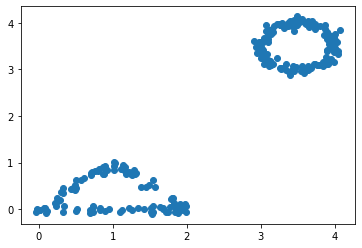

In [115]:
plt.scatter(samples[0,:,0], samples[0,:,1])

# Main model

In [137]:
from itertools import chain

class MainModel(nn.Module):
    def __init__(self, dim, blocks, flow_length, base_distributions, transition_matrix=None, device='cpu'):
        super().__init__()
        
        self.flows = []
        for d in base_distributions:
            self.flows.append(NormalizingFlow(dim=dim,device=device,blocks=blocks,flow_length=flow_length,
                                              base_distrib=d))    
        
        self.device = device
        self.hmm = HMM(len(self.flows),self.flows,transition_matrix=transition_matrix)
    
    def forward(self, x, T):
        return self.hmm(x, T)
    
    def parameters(self):
        return chain(*[f.parameters() for f in self.flows])
    
    def to(self, device):
        super().to(device)
        self.hmm.to(device)

        for f in self.flows:
            f.to(device)
            
        return self

In [133]:
def hmm_step(hmm_object, x, T):
    hmm_object.forward_backward_step(x, T)

In [134]:
def nf_step(model, x, T, optimizer):
    optimizer.zero_grad()
    
    loss = - model(x, T)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [135]:
from torch.utils.data import DataLoader

def train_MainModel(model, dataset, batch_size, epochs, optimizer):
    model.train()
    dataloader = DataLoader(dataset,batch_size=batch_size)
    
    for epoch in range(epochs):
        turn = epoch % 2
        
        for batch, x in enumerate(dataloader):
            loc_batch_size = x.shape[0]
            T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
            if turn==1:
                hmm_step(model.hmm, x, T)
            else:
                nf_step(model, x, T, optimizer)
            turn = - turn + 1

In [139]:
main_model.hmm.emission_model.to(device)

EmissionModel()

In [142]:
main_model.hmm.log_normalized_state_priors

tensor([-0.6931, -0.6931])

In [140]:
block = [CouplingFlow, ReverseFlow]
ref_distrib = distrib.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
main_model = MainModel(2,block,8,[ref_distrib]*2,device=device)
main_model.to(device)
flow_optimizer = optim.Adam(main_model.parameters(), lr=0.0003, weight_decay=0.001)

train_MainModel(main_model,my_dataset,5,10,flow_optimizer)

EmissionModel() -1


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ref_distrib = distrib.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
block = [CouplingFlow, ReverseFlow]
my_flow = NormalizingFlow(dim = 2, device = device, blocks = block, flow_length = 8, base_distrib = ref_distrib)
# Create optimizer algorithm
flow_optimizer = optim.Adam(flow.parameters(), lr=0.0003, weight_decay=0.001)
# Add learning rate scheduler
flow_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)